# From the address to the 3D

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geopy as gp
import folium

from shapely.geometry import Point, Polygon

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [6]:
from functions import *
from raster2xyz import raster2xyz

## Enter an address, get a location

In [7]:
# Google API

country_code = -1

while country_code != 'BE':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.geocoders.GoogleV3(api_key='')
    location = locator.geocode(address, timeout=10)

    postcode = int(location.raw['address_components'][-1]['long_name'])
    country_code = location.raw['address_components'][-2]['short_name']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
Rue neuve, 39 1350
Latitude = 4.9318328, Longitude = 50.6588103, Postcode = 1350


In [3]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[0], coord[1], postcode))

Please, enter an address in Begium:
Gare de Namur
Latitude = 50.469100100000006, Longitude = 4.862421313946799, Postcode = 5000


In [8]:
mappy = folium.Map(
    location=[coord[0],coord[1]],
    zoom_start=17
)

folium.CircleMarker(
    location=[coord[0],coord[1]],
    radius=30,
    popup='Your address',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(mappy)

mappy

## From coordinates to correct crs

In [9]:
p = gpd.GeoSeries([Point(coord[1], coord[0])])
p.crs = 'epsg:4326'
p = p.to_crs(epsg=31370)
print(p[0])

POINT (189813.7284753995 149950.3678983543)


## Get a Polygon around the point

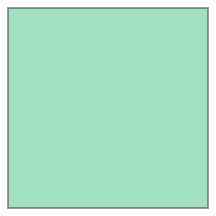

In [10]:
x = p[0].x
y = p[0].y

poly = Polygon([(x+100, y+100), (x-100, y+100), (x-100, y-100), (x+100, y-100)])
poly

## Get the corrects LiDAR files' path

In [11]:
path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        path_dsm = f'/home/demes/Documents/Resources/Flandre/DSM/DHMVIIDSMRAS1m_k{i:02}/GeoTIFF/DHMVIIDSMRAS1m_k{i:02}.tif'
        with rio.open(path_dsm) as dsm:
            #coordinates = (
             #   (x+100, y+100), (x-100, y-100)
            #)
            coordinates = (
                (p[0].x, p[0].y),
            )
            for i, (lon, lat) in enumerate(coordinates):
                # Get pixel coordinates from map coordinates
                print(lon, lat)
                py, px = dsm.index(lon, lat)
                print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window
                small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
    flanders = True
    print('Brussels or Flanders region')

Walloon Brabant


## Get a sample of the LiDARs, center on the coordinates

[Highlight on "no value's data"](https://github.com/Demesmaeker/3D_Houses/blob/main/App/highlight_on_no_values_data.ipynb)

##### DSM

/home/demes/Documents/Ressources/Wallonia/DSM 2013-2014/RELIEF_WALLONIE_MNS_2013_2014_GEOTIFF_31370_PROV_BRABANT_WALLON/RELIEF_WALLONIE_MNS_2013_2014.tif
Pixel Y, X coords: 18049, 59813


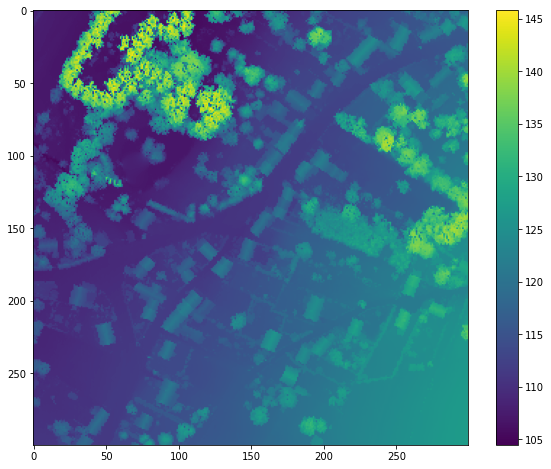

In [12]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 300

print(path_dsm)

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dsm_meta = dsm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dsm)
plt.colorbar()
plt.show()

##### DTM

Pixel Y, X coords: 18049, 59813


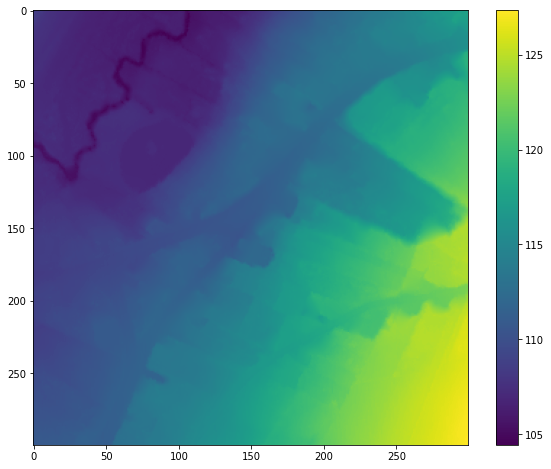

In [13]:
with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dtm_meta = dtm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dtm)
plt.colorbar()
plt.show()

## Canopy Height Model

[Highlight on Canopy Height Model and Hillshade](https://github.com/Demesmaeker/3D_Houses/blob/main/App/Highlight%20on%20the%20Canopy%20Height%20Model%20and%20Hillshade.ipynb)

In [14]:
lidar_chm = small_dsm - small_dtm

## Transform raster into xyz datas

In [15]:
shape = [{'type': 'Polygon', 
          'coordinates': [[(x+50, y+50), 
                           (x-50, y+50), 
                           (x-50, y-50), 
                           (x+50, y-50)]]}]

In [16]:
datas = raster2xyz.translate_from_cropped(get_mask(path_dsm, shape))

In [17]:
raw_df = datas[0]

raw_df.describe()

,x,y,z
count,10201.000000,10201.000000,10201.000000
mean,50.000000,-50.000000,115.112076
std,29.156189,29.156189,4.122600
min,0.000000,-100.000000,106.980003
25%,25.000000,-75.000000,111.519997
50%,50.000000,-50.000000,114.470001
75%,75.000000,-25.000000,117.769997
max,100.000000,0.000000,133.830002


In [18]:
bases = datas[1]
bases

(189763.0000000021, 150000.99999999837)

In [19]:
df = pd.DataFrame()

df['x'] = raw_df['x'] + bases[0]
df['y'] = raw_df['y'] + bases[1]
df['z'] = raw_df['z']

df.describe()

,x,y,z
count,10201.000000,10201.000000,10201.000000
mean,189813.000000,149951.000000,115.112076
std,29.156189,29.156189,4.122600
min,189763.000000,149901.000000,106.980003
25%,189788.000000,149926.000000,111.519997
50%,189813.000000,149951.000000,114.470001
75%,189838.000000,149976.000000,117.769997
max,189863.000000,150001.000000,133.830002


In [20]:
df

,x,y,z
0,189763.0,150001.0,107.010002
1,189764.0,150001.0,107.029999
2,189765.0,150001.0,107.019997
3,189766.0,150001.0,107.000000
4,189767.0,150001.0,107.199997
...,...,...,...
10196,189859.0,149901.0,119.209999
10197,189860.0,149901.0,120.459999
10198,189861.0,149901.0,120.459999
10199,189862.0,149901.0,122.910004


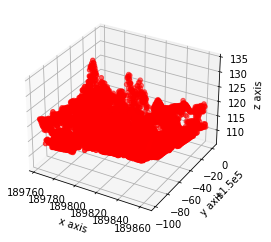

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = df['x']
Y = df['y']
Z = df['z']

ax.scatter(X, Y, Z, c='r', marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.show()

In [22]:
df.to_csv('../Outputs/df.txt', header=None, index=None, sep=' ', mode='a')

In [23]:
pcd = o3d.io.read_point_cloud("../Outputs/df.txt", format='xyz')
pcd

NameError: name 'o3d' is not defined

In [ ]:
print(np.asarray(pcd.points))

In [ ]:
o3d.visualization.draw_geometries([pcd])

TO DO :
    
Flandre :
    "Get the file"
    analyser shapefile pour obtenir coordonnées min/max
    selectionner les bons fichiers
    avoir le système de référence (crs)
    transformer coord das le système de référence
    
Les deux :
    Projection 3D
    Select one house only